<a href="https://colab.research.google.com/github/nikita-resh/StyleGAN-NADA/blob/main/miain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install Ninja

import torch
import matplotlib.pyplot as plt
import gdown
import clip
import gc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1iux4m1h
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-1iux4m1h
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!git clone https://github.com/rosinality/stylegan2-pytorch.git

Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 395, done.
remote: Total 395 (delta 0), reused 0 (delta 0), pack-reused 395 (from 1)
Receiving objects: 100% (395/395), 122.51 MiB | 21.74 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [3]:
%cd stylegan2-pytorch

/content/stylegan2-pytorch


In [4]:
from model import Generator

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [5]:
file_path = "/content/stylegan2-pytorch/lpips/__init__.py"

# Откроем файл и прочитаем его содержимое
with open(file_path, "r") as file:
    lines = file.readlines()

# Заменим нужную строку
with open(file_path, "w") as file:
    for line in lines:
        # Если в строке есть "compare_ssim", заменим на "structural_similarity"
        if "from skimage.measure import compare_ssim" in line:
            file.write("from skimage.metrics import structural_similarity\n")
        else:
            file.write(line)

print("Замена выполнена успешно!")

Замена выполнена успешно!


In [6]:
# Зададим девайс: cuda или cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# URL for the Google Drive file
url = "https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT"

# Download the file
gdown.download(url, "stylegan2-ffhq-config-f.pt", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT
From (redirected): https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT&confirm=t&uuid=9b9752f8-65b3-4a46-9a03-102e080dae3c
To: /content/stylegan2-pytorch/stylegan2-ffhq-config-f.pt
100%|██████████| 381M/381M [00:11<00:00, 34.4MB/s]


'stylegan2-ffhq-config-f.pt'

### CLIP Loss

We want the model to generate images that align with the properties described in the text prompt. To achieve this, we use CLIP loss to encourage the model to generate images that are closer to the text description in the CLIP embedding space.

The CLIP loss is computed as follows:

$$
D_{\text{CLIP}} = 1 - \frac{\langle E_T(G(w)) \cdot E_T(t) \rangle }{\|E_T(G(w))\| \cdot \|E_T(t)\|}
$$

**Where:**

- $E_T$: Text and image encoder function (e.g., CLIP's shared encoder for both text and image).
- $t$: Text description (prompt).
- $G(w)$: Image generated by the generator using the latent vector $w$.
- $D_{\text{CLIP}}$: Cosine distance between the text embedding and the image embedding in the CLIP space.

**Intuition:** The CLIP loss encourages the generated image $G(w)$ to be semantically aligned with the provided text prompt $t$. If the image and text embeddings are close in the CLIP space, the loss will be small, helping the model generate images that reflect the described properties.


In [8]:
class CLIPLoss(torch.nn.Module):
    def __init__(self, stylegan_size=1024):
        super(CLIPLoss, self).__init__()

        self.model, self.preprocess = clip.load("ViT-B/32", device=device)

        # clip only supports images 224*224.
        # we need to resize image with min information loss possible. therefore we firstly apply upsamling, and then pooling.
        # scale_factor=7 allows not to deal with decimals
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=(1024 * 7 // 224))

    def forward(self, prompt, image):
        # text preprocessing
        tokenized_prompt = clip.tokenize([prompt]).to(device)
        # image preprocessing
        preprocessed_image = self.avg_pool(self.upsample(image))
        # encoding to CLIP space
        text_features = self.model.encode_text(tokenized_prompt)  # Remove .detach()
        image_features = self.model.encode_image(preprocessed_image)  # Remove .detach()

        # normalize embeddings
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        similarity = (image_features * text_features).sum(dim=1)
        loss = 1 - similarity.mean()

        return loss

### CLIP Directional loss

We want to only change properties described in our text prompt. We use CLIP loss to panish model for changing other properties.

The directional loss is computed as follows:

$$
\Delta T = E_T(t_{\text{target}}) - E_T(t_{\text{source}})
$$

$$
\Delta I = E_I(G_{\text{train}}(w)) - E_I(G_{\text{frozen}}(w))
$$

$$
L_{\text{direction}} = 1 - \frac{\Delta I \cdot \Delta T}{|\Delta I| \cdot |\Delta T|}
$$

**Where:**

- $E_T$: Text encoder function (e.g., CLIP text encoder).
- $E_I$: Image encoder function (e.g., CLIP image encoder).
- $t_{\text{target}}$: Target text description.
- $t_{\text{source}}$: Source text description.
- $G_{\text{train}}$: Trainable generator (e.g., StyleGAN during training).
- $G_{\text{frozen}}$: Frozen generator (pre-trained StyleGAN, unmodified during training).
- $w$: Latent vector input to the generator.

**Intuition:** If the image changes $\Delta I$ don’t align with the text changes $\Delta T$, the loss increases, encouraging the generator to better follow the text guidance during optimization.


In [9]:
class CLIPDirectionalLoss(torch.nn.Module):
    def __init__(self, stylegan_size=1024):
        super(CLIPDirectionalLoss, self).__init__()

        self.model, self.preprocess = clip.load("ViT-B/32", device=device)

        # clip only supports images 224*224.
        # we need to resize image with min information loss possible. therefore we firstly apply upsamling, and then pooling.
        # scale_factor=7 allows not to deal with decimals
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=(1024 * 7 // 224))

    def forward(
        self,
        frozen_generator_image,
        trainable_generator_image,
        source_prompt,
        target_prompt,
    ):
        # text preprocessing
        tokenized_source_prompt = clip.tokenize([source_prompt]).to(device)
        tokenized_target_prompt = clip.tokenize([target_prompt]).to(device)
        # image preprocessing
        preprocessed_frozen_generator_image = self.avg_pool(
            self.upsample(frozen_generator_image)
        )
        preprocessed_trainable_generator_image = self.avg_pool(
            self.upsample(trainable_generator_image)
        )

        # encoding to CLIP space
        source_prompt_features = self.model.encode_text(tokenized_source_prompt)
        target_prompt_features = self.model.encode_text(tokenized_target_prompt)
        frozen_generator_image_features = self.model.encode_image(
            preprocessed_frozen_generator_image
        )
        trainable_generator_image_features = self.model.encode_image(
            preprocessed_trainable_generator_image
        )

        delta_t = target_prompt_features - source_prompt_features
        delta_i = trainable_generator_image_features - frozen_generator_image_features

        # normalize deltas
        delta_i = delta_i / delta_i.norm(dim=1, keepdim=True)
        delta_t = delta_t / delta_t.norm(dim=1, keepdim=True)

        loss = 1 - (delta_i * delta_t).sum(dim=1).mean()

        return loss

In [10]:
clip_loss = CLIPLoss()
clip_directional_loss = CLIPDirectionalLoss()

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 75.4MiB/s]


In [11]:
# Параметры генератора
size = 1024  # Размер изображения
latent_dim = 512  # Размер латентного пространства
n_mlp = 8  # Количество слоев MLP
channel_multiplier = 2
ckpt = "/content/stylegan2-pytorch/stylegan2-ffhq-config-f.pt"  # Путь к весам StyleGAN2

In [12]:
frozen_generator = Generator(
    size, latent_dim, n_mlp, channel_multiplier=channel_multiplier
).to(device)
trainable_generator = Generator(
    size, latent_dim, n_mlp, channel_multiplier=channel_multiplier
).to(device)

frozen_generator.eval()
trainable_generator.train()

checkpoint = torch.load(ckpt)

frozen_generator.load_state_dict(checkpoint["g_ema"])
trainable_generator.load_state_dict(checkpoint["g_ema"])

<ipython-input-12-0f2224f1e908>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt)


<All keys matched successfully>

In [13]:
def freeze_stylegan_layers(generator, selected_layers=None):
    """
    Freezes specific layers in a StyleGAN generator.

    Args:
        generator: The StyleGAN generator model.
        selected_layers: A list of indices of layers that should remain trainable.
                         If None, only Mapping Network, Affine Transformations, and ToRGB layers are frozen.
    """
    # Always freeze Mapping Network (style), ToRGB layers, and Affine Transformations
    modules_to_freeze = ["style", "to_rgb1"]

    for module in modules_to_freeze:
        if hasattr(generator, module):
            for param in getattr(generator, module).parameters():
                param.requires_grad = False

    # Freeze all ToRGB layers in the ModuleList
    if hasattr(generator, "to_rgbs"):
        for to_rgb_layer in generator.to_rgbs:
            for param in to_rgb_layer.parameters():
                param.requires_grad = False

    # If selected_layers is provided, freeze all other conv layers
    if selected_layers is not None:
        for i, conv in enumerate(generator.convs):
            if i not in selected_layers:  # Freeze layers not in the selected list
                for param in conv.parameters():
                    param.requires_grad = False

In [14]:
# freeze_stylegan_layers(frozen_generator)
# freeze_stylegan_layers(trainable_generator)

In [18]:
batch_size = 4  # Number of images to use in each step
num_steps = 301

l2_lambda = 1.0
clip_lambda = 2.5
clip_directional_lambda = 1.2
id_lambda = 0.0005
num_layers = 18


optimizer = torch.optim.Adam(trainable_generator.parameters(), lr=0.01)

source_prompt = "photo"
target_prompt = "zombie"

In [19]:
def get_k_relevant_layers(generator, k, target_prompt):
    latent_z = torch.randn((batch_size, latent_dim), device=device)

    generator.eval()
    with torch.no_grad():
        latent_w = generator.style(latent_z).detach()
        latent_w_plus = latent_w.unsqueeze(1).repeat(1, num_layers, 1).detach().clone()

    latent_w_plus.requires_grad_(True)  # Указываем requires_grad_ отдельно

    # Сохраняем начальное состояние
    initial_w_plus = latent_w_plus.clone().detach()

    relevant_optimizer = torch.optim.Adam([latent_w_plus], lr=0.01)

    for step in range(10):
        relevant_optimizer.zero_grad()

        image, _ = generator([latent_w_plus], input_is_latent=True, randomize_noise=False)
        loss = clip_lambda * clip_loss(target_prompt, image)

        loss.backward()  # `loss.requires_grad = True` не нужен
        relevant_optimizer.step()

    # Вычисляем изменения после оптимизации
    delta_w = (latent_w_plus.detach() - initial_w_plus).abs().mean(dim=(0, 2))
    print(delta_w)

    # Выбираем k слоёв с наибольшими изменениями
    relevant_layers = delta_w.topk(k).indices.tolist()

    return relevant_layers

In [20]:
get_k_relevant_layers(trainable_generator, 10, target_prompt)

/content/stylegan2-pytorch/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.5.1+cu124. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


tensor([0.0247, 0.0323, 0.0332, 0.0342, 0.0436, 0.0458, 0.0477, 0.0490, 0.0472,
        0.0534, 0.0449, 0.0598, 0.0516, 0.0502, 0.0436, 0.0532, 0.0584, 0.0518],
       device='cuda:0')


[11, 16, 9, 15, 17, 12, 13, 7, 6, 8]

tensor([0.0260, 0.0275, 0.0291, 0.0320, 0.0387, 0.0433, 0.0438, 0.0464, 0.0444,
        0.0547, 0.0510, 0.0604, 0.0522, 0.0618, 0.0459, 0.0576, 0.0680, 0.0616],
       device='cuda:0')
[16, 13, 17, 11, 15, 9, 12, 10, 7, 14]
Step [0/301], Loss: 3.2216796875


KeyboardInterrupt: 

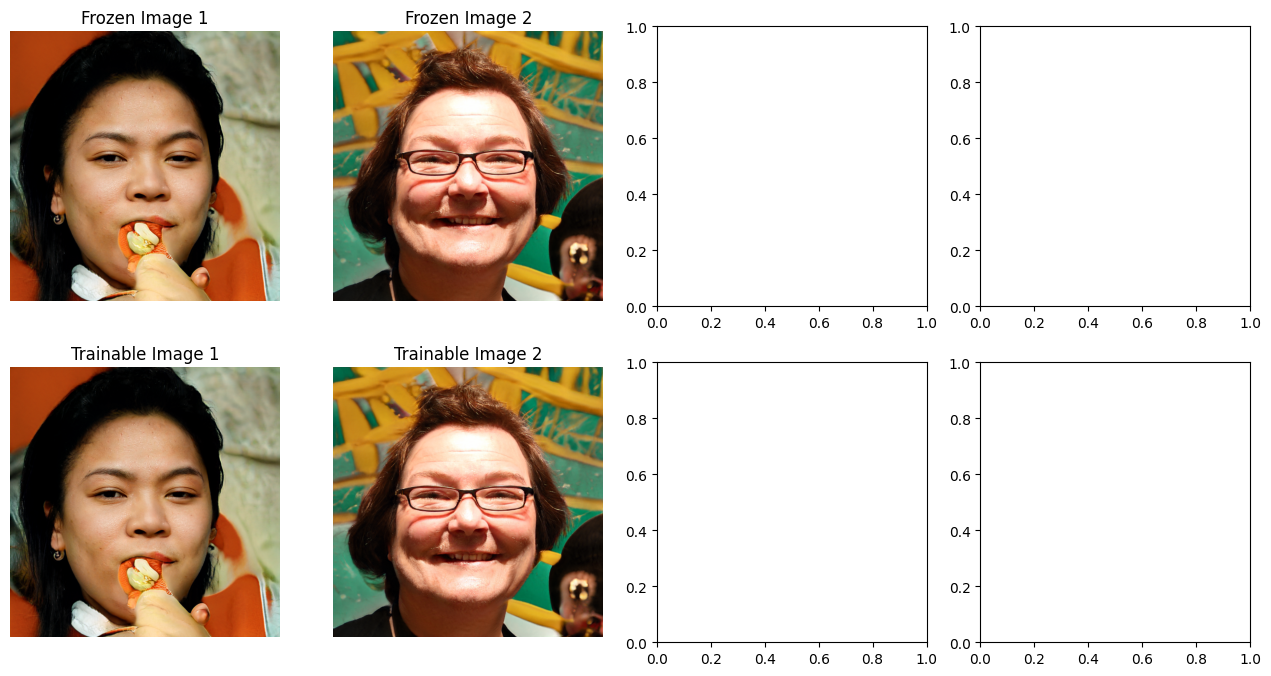

In [21]:
losses = {"l2": [], "clip": [], "clip_directional": [], "total": []}

# Количество стилевых модулей в генераторе (обычно 18 для StyleGAN2)
for step in range(num_steps):
    optimizer.zero_grad()

    k_relevant_layers = get_k_relevant_layers(trainable_generator, 10, target_prompt)
    print(k_relevant_layers)

    # Генерация латентных векторов
    latent_z = torch.randn((batch_size, latent_dim), device=device)

    # Проекция в W+ пространство
    latent_w = frozen_generator.style(latent_z).detach().clone()
    latent_w_plus = latent_w.unsqueeze(1).repeat(
        1, num_layers, 1
    )  # [batch_size, num_layers, latent_dim]

    # Генерация изображений в W+ пространстве
    with torch.no_grad():
        frozen_generator_images, _ = frozen_generator(
            [latent_w_plus], input_is_latent=True, randomize_noise=False
        )
    trainable_generator_images, _ = trainable_generator(
        [latent_w_plus], input_is_latent=True, randomize_noise=False
    )

    # Вычисление потерь
    l2_loss_value = torch.mean(
        (frozen_generator_images - trainable_generator_images) ** 2
    )
    clip_loss_value = clip_loss(target_prompt, trainable_generator_images)
    clip_directional_loss_value = clip_directional_loss(
        frozen_generator_images,
        trainable_generator_images,
        source_prompt,
        target_prompt,
    )

    # Комбинирование потерь
    loss = (
        l2_lambda * l2_loss_value
        + clip_lambda * clip_loss_value
        + clip_directional_lambda * clip_directional_loss_value
    )

    # Логирование потерь
    losses["l2"].append(l2_loss_value.detach().item())
    losses["clip"].append(clip_loss_value.detach().item())
    losses["clip_directional"].append(clip_directional_loss_value.detach().item())
    losses["total"].append(loss.detach().item())

    # Обратное распространение ошибки и обновление весов
    loss.backward()
    optimizer.step()

    # Visualization and logging
    if step % 20 == 0 or step == num_steps - 1:
        print(f"Step [{step}/{num_steps}], Loss: {losses['total'][-1]}")

        # Create subplots to visualize both frozen and trainable images side-by-side
        fig, axs = plt.subplots(
            2, batch_size, figsize=(batch_size * 4, 8)
        )  # 2 rows, batch_size columns

        # If batch_size = 1, axs will not be iterable, so wrap it in a list
        if batch_size == 1:
            axs = [[axs[0]], [axs[1]]]

        for i in range(batch_size):
            # Display frozen_generator_images (row 0)
            axs[0][i].imshow(
                (
                    frozen_generator_images.cpu()
                    .detach()[i]
                    .clip(-1, 1)
                    .permute(1, 2, 0)
                    + 1
                )
                / 2
            )
            axs[0][i].set_title(f"Frozen Image {i+1}")
            axs[0][i].axis("off")

            # Display trainable_generator_images (row 1)
            axs[1][i].imshow(
                (
                    trainable_generator_images.cpu()
                    .detach()[i]
                    .clip(-1, 1)
                    .permute(1, 2, 0)
                    + 1
                )
                / 2
            )
            axs[1][i].set_title(f"Trainable Image {i+1}")
            axs[1][i].axis("off")

        plt.tight_layout()
        plt.show()

    # Clear cached data to free up memory
    del frozen_generator_images, trainable_generator_images, latent_w, latent_z
    torch.cuda.empty_cache()

In [ ]:
# Steps corresponding to the losses
steps = range(len(losses["total"]))

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Losses Over Steps", fontsize=16)

# Titles and keys for the losses
titles = ["L2 Loss", "CLIP Loss", "CLIP Directional", "Total Loss"]
loss_keys = ["l2", "clip", "clip_directional", "total"]

# Plot each loss
for i, ax in enumerate(axs.flat):
    loss_key = loss_keys[i]
    ax.plot(steps, losses[loss_key], marker="o", label=f"{loss_key.upper()} Loss")
    ax.set_title(titles[i])
    ax.set_xlabel("Step")
    ax.set_ylabel("Loss")
    ax.grid(True)
    ax.legend()

# Adjust layout to fit the title and spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
torch.cuda.empty_cache()

# Move tensors to CPU and delete them
del frozen_generator  # Assuming `model` is your trained model
del trainable_generator  # Assuming `model` is your trained model
torch.cuda.empty_cache()

# Collect garbage to clear references
gc.collect()